In [7]:
import numpy as np
import pandas as pd
#import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, StandardScaler
from sklearn.naive_bayes import ComplementNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone 
%matplotlib inline

In [10]:
df = pd.read_excel('./data/Bank_Personal_Loan_Modelling.xlsx', sheet_name='Data')
df.head(5)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [11]:
df.drop('ID', axis=1, inplace=True) 

In [12]:
df.head(5)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [13]:
df.drop(df[df['ZIP Code']<20000].index, inplace=True)
df.reset_index(drop=True, inplace =True)

In [15]:
df['Experience'] = df['Experience'].apply(abs)

In [16]:
outlier_indexes = df[stats.zscore(df['Mortgage'])>3].index
df.drop(outlier_indexes, inplace=True)
df.reset_index(drop=True, inplace=True)

In [17]:
df['CCAvg'] = df['CCAvg']*12

In [18]:
# Define a list containing the names of important categorical features in the dataset 
Cat_Features = ['CD Account','Education','Family','Securities Account','Online','Securities Account']

# Define the target name in a variable for simplicity
Target = 'Personal Loan'

In [19]:
# Define a list containing the names of important numerical features in the dataset 
Num_Features = ['CCAvg','Income','Mortgage','Age','Experience']

In [20]:
# we remove Experience because it doesn't provide any more information than Age:
df.drop('Experience', axis=1, inplace=True)

In [21]:
X = df.drop('Personal Loan', axis=1)
y = df['Personal Loan'] 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [23]:
# Define a scorer function
def f1_metric(model, X_train, y_train):
    '''
    This function reports f1-score metric for the class specified by 'Positive Label' (or '1')
    '''
    return f1_score(y_train, model.predict(X_train), average='binary')

In [27]:
def drop_column_importance(model, X_train, y_train, random_state=0):
    # list containing feature importances
    importances = []
    # Clone the model
    model_clone = clone(model)
    # Set random_state for comparability
    model_clone.random_state = random_state
    # Train the model
    model_clone.fit(X_train, y_train)
    # Create the cross-validation object using StratifiedKFold 
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
    # Score the benchmark model using cross-validation
    benchmark_score = cross_val_score(model_clone, X_train, y_train, cv=cv, scoring=f1_metric).mean()

    
    # Iterate over all features and store feature importance
    for col in X_train.columns:
        # Clone the model
        model_clone = clone(model)
        # Set random_state for comparability
        model_clone.random_state = random_state
        # Traint the model on the the dataset with a single feature removed
        model_clone.fit(X_train.drop(col, axis = 1), y_train)
        # Score the droped-column model
        drop_column_score = cross_val_score(model_clone, X_train.drop(col,axis=1), y_train, cv=cv, scoring=f1_metric).mean()
        # Store feature importance which is defined as the difference between the benchmark and the new model score
        importances.append(benchmark_score - drop_column_score)
        
    # Return the features along with their importances in the form of a dataframe
    importances_df = pd.DataFrame({'feature': X_train.columns, 'feature importance': importances}) \
                     .sort_values('feature importance', ascending = False).reset_index(drop = True)
           
    return importances_df          

In [24]:
# Define imbalance ratio
ratio = sum(y_train==0)/sum(y_train==1) 

# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 5, 10],
    'scale_pos_weight': [ratio, ratio*1.3, ratio*1.5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'colsample_bylevel': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'max_delta_step': [0, 1, 2],
    'gamma': [0, 0.1, 1],
    'max_leaf_nodes': [2, 4, 6]
}

In [25]:
# Initialize the XGBoost Classifier
xgb_opt = XGBClassifier(max_depth=5,
                        learning_rate=0.3,
                        n_estimators=200,
                        min_child_weight=1,
                        scale_pos_weight=1.5,
                        colsample_bytree=0.8,
                        gamma=0.1,
                        booster='gbtree',
                        objective='binary:logistic',
                        eval_metric='error', 
                        random_state=0)

# Train the XGBoost Classifier
xgb_opt.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [28]:
# Find Important features
feature_importances = drop_column_importance(xgb_opt, X_train, y_train, 0)
selected_features = feature_importances[feature_importances['feature importance']>0.002]['feature'] # Threshold value of 0.002

# Filter dataset
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [29]:
X_train.head()

,Education,Income,Family,CCAvg,CD Account,Age,CreditCard,Online,ZIP Code
1372,3,75,1,16.8,0,58,0,1,92121
1662,1,140,2,91.2,0,45,0,0,91024
4776,1,73,3,28.0,1,43,1,1,94301
2791,3,79,4,43.2,0,49,0,1,94025
2174,3,80,1,9.6,0,65,0,1,94105


In [30]:
# Initialize the XGBoost Classifier
xgb = XGBClassifier(max_depth=5,
                    learning_rate=0.3,
                    n_estimators=200,
                    min_child_weight=1,
                    scale_pos_weight=1.5,
                    colsample_bytree=0.8,
                    gamma=0.1,
                    booster='gbtree',
                    objective='binary:logistic',
                    eval_metric='error', 
                    random_state=0)

# Train the XGBoost Classifier
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

In [32]:
def metrics_calculator(clf, X_test, y_test, model_name):
    '''
    This function calculates all desired performance metrics for a given model on test data.
    '''
    y_pred = clf.predict(X_test)
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='binary'),
                                recall_score(y_test, y_pred, average='binary'),
                                f1_score(y_test, y_pred, average='binary'),
                                roc_auc_score(y_test, clf.predict_proba(X_test)[::,1])],
                          index=['Accuracy','Precision','Recall','F1-score','AUC'],
                          columns = [model_name])
    
    result = (result * 100).round(2).astype(str) + '%'                            
    return result

In [35]:
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports, 
    confusion matrix and ROC curve.
    '''
    sns.set(font_scale=1.2)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    
    # Create figure and subplots 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=100, gridspec_kw={'width_ratios': [2, 2, 1]})
    
    # Plot confusion matrix for test set
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, colorbar=False, ax=ax1)
    ax1.set_title('Confusion Matrix for Test Data')                                     
    ax1.grid(False)
    
    # Plot ROC curve for test data and display AUC score 
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax2)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve for Test Data (Positive label: 1)')
    
    # Report results for the class specified by positive label
    result = metrics_calculator(clf, X_test, y_test, model_name)
    table = ax3.table(cellText=result.values, colLabels=result.columns, rowLabels=result.index, loc='center')
    table.scale(0.6, 2)
    table.set_fontsize(12)
    ax3.axis('tight')
    ax3.axis('off')
    # Modify color 
    for key, cell in table.get_celld().items():
        if key[0] == 0:
            cell.set_color('royalblue')
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.99      0.91      0.95        87

    accuracy                           0.99       979
   macro avg       0.99      0.95      0.97       979
weighted avg       0.99      0.99      0.99       979



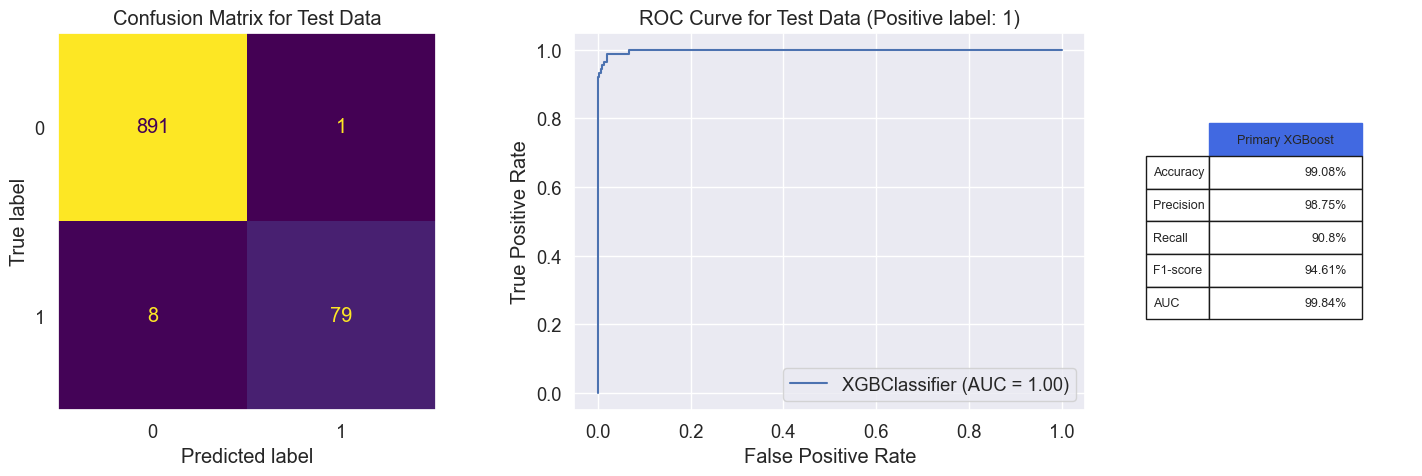

In [36]:
model_evaluation(xgb, X_train, X_test, y_train, y_test, 'Primary XGBoost')

In [37]:
# Initialize the XGBoost Classifier
xgb_final = XGBClassifier(max_depth=4,
                          learning_rate=0.3,
                          n_estimators=200,
                          min_child_weight=1,
                          scale_pos_weight=1.5,
                          colsample_bytree=0.8,
                          gamma=0.1,
                          booster='gbtree',
                          objective='binary:logistic',
                          eval_metric='error', 
                          random_state=0)

# Train the XGBoost Classifier
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='error', feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3569
           1       1.00      1.00      1.00       346

    accuracy                           1.00      3915
   macro avg       1.00      1.00      1.00      3915
weighted avg       1.00      1.00      1.00      3915


	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       892
           1       0.98      0.92      0.95        87

    accuracy                           0.99       979
   macro avg       0.98      0.96      0.97       979
weighted avg       0.99      0.99      0.99       979



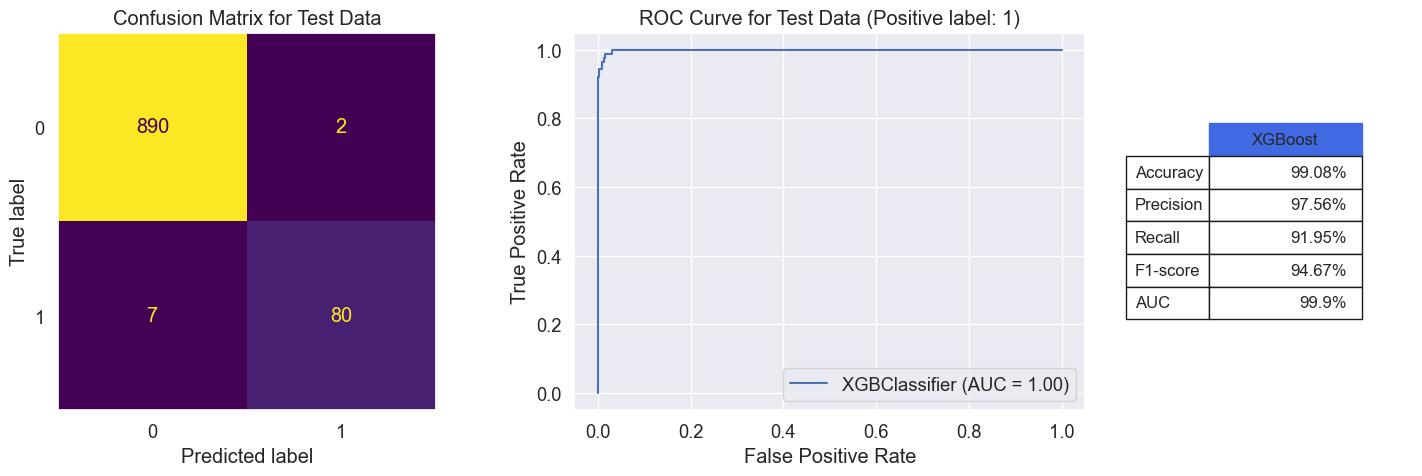

In [38]:
model_evaluation(xgb_final, X_train, X_test, y_train, y_test, 'XGBoost')